In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import pickle

# Group cells via the MaxEnt couplings

Couplings are dervied using the model described in this paper:
</br>
Hoshal, Benjamin D., Caroline M. Holmes, Kyle Bojanek, Jared Salisbury, Michael J. Berry, Olivier Marre, and Stephanie E. Palmer. "Stimulus invariant aspects of the retinal code drive discriminability of natural scenes." bioRxiv (2023).
</br>
</br>
After computing the pairwise couplings $J$, we start from the 1st cell and move in a loop of couplings until the $J_{ij}$ falls below a certain threshold. 
We put all cells of the loop in the same group. We repeat this procedure until all cells are assigned to a group.

In [2]:
# load the couplings
data_path = '../../data/matlab_data/'
# maxent_model = scipy.io.loadmat(data_path+'model_rtpairwise_notconverged.mat')
maxent_model = scipy.io.loadmat(data_path+'model_rtpairwise_converged_15.mat')

In [3]:
ncell = int(maxent_model['model'][0][0][0][0][0])
model_type = maxent_model['model'][0][0][1][0]
nrepeats = int(maxent_model['model'][0][0][2][0][0])
nframes = int(maxent_model['model'][0][0][3][0][0])
factors = maxent_model['model'][0][0][4][0]
step_scaling = maxent_model['model'][0][0][5][0]
# z = maxent_model['model'][0][0][6][0][0]
# model_entropy = maxent_model['model'][0][0][7][0][0]
print(ncell, model_type, nrepeats, nframes, factors.shape, step_scaling.shape)

113 rtpairwise 297 1141 (135261,) (135261,)


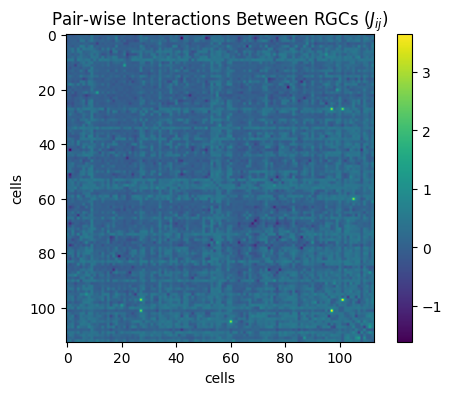

In [4]:
# visualize the factors
h = factors[:ncell*nframes]
J = np.zeros((ncell, ncell))

m = 0
for i in range(ncell):
    for j in range(i+1, ncell):
        J[i,j] = factors[ncell*nframes+m]
        J[j,i] = J[i,j]
        m += 1
    
plt.figure(figsize=(6,4))
plt.imshow(J)
plt.colorbar()
plt.xlabel('cells')
plt.ylabel('cells')
_ = plt.title('Pair-wise Interactions Between RGCs ($J_{ij}$)')

min = -1.618	min_mag = 0.000033	max =  3.656
mean = 0.158	median = 0.118	80%quantile = 0.413


Text(0, 0.5, 'count')

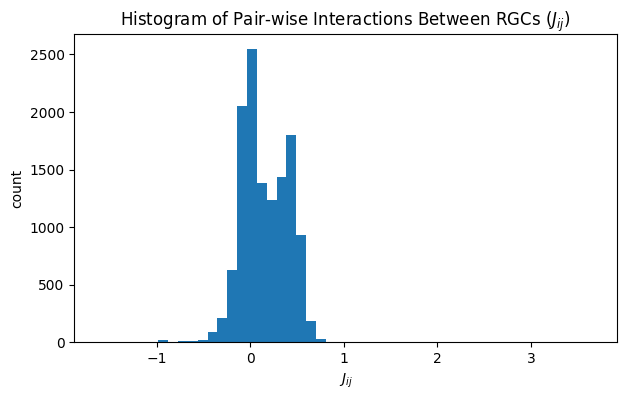

In [5]:
# explore the couplings - basic statistics
J_nondiag = J[~np.eye(J.shape[0],dtype=bool)]
print('min = {:.3f}\tmin_mag = {:.6f}\tmax =  {:.3f}'.format(np.min(J_nondiag), np.min(np.abs(J_nondiag)), np.max(J_nondiag)))
print('mean = {:.3f}\tmedian = {:.3f}\t80%quantile = {:.3f}'.format(np.mean(J_nondiag), np.median(J_nondiag), np.quantile(J_nondiag, 0.80)))

plt.figure(figsize=(7,4))
counts_bins = plt.hist(J_nondiag, bins=50)
plt.title('Histogram of Pair-wise Interactions Between RGCs ($J_{ij}$)')
plt.xlabel('$J_{ij}$')
plt.ylabel('count')

threshold = 95% quantile = 0.5611696886746993
num groups: 50


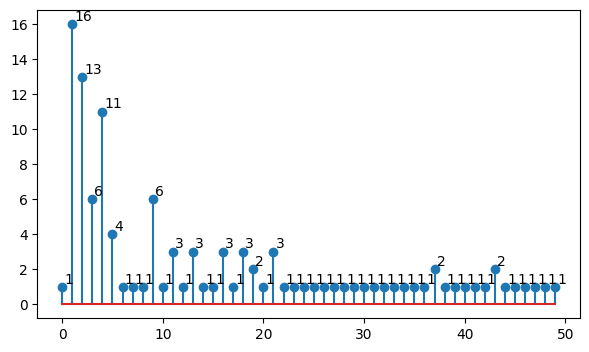

In [6]:
# set the threshold
quant = 0.95
threshold = np.quantile(J_nondiag[J_nondiag>0], quant)
print('threshold = {:.0f}% quantile = {}'.format(quant*100, threshold))

# group cells
cells_remaining = list(range(ncell)) # cells are numbered starting 0
groups = []

while len(cells_remaining) > 0:
    curr_group = []
    curr_cell = cells_remaining[0]  
    curr_group.append(curr_cell)
    cells_remaining.remove(curr_cell)   
    
    while len(cells_remaining) > 0:  
        curr_couples = np.array(list(enumerate(J[curr_cell])))[cells_remaining]
        best_couple = int(curr_couples[np.argmax(curr_couples[:,1]), 0])
        if J[curr_cell, best_couple] > threshold:
            curr_group.append(best_couple)
            cells_remaining.remove(best_couple)
            curr_cell = best_couple
        else:
            break
    
    groups.append(curr_group)

# sanity check: sum of the # of cells in all groups == # of cells
group_lengths = [len(group) for group in groups]
assert sum(group_lengths) == ncell

# visualize the groups
print('num groups:', len(groups))
plt.figure(figsize=(7,4))
plt.stem(np.arange(len(groups)), group_lengths)
for i in range(len(groups)):
    plt.text(i+0.2, group_lengths[i]+0.2, group_lengths[i])

In [7]:
# save the largest groups
large_size = 10
groups_large = [group for group in groups if len(group) > large_size]
print('There are {} groups larger than {}.\nThe lengths of these groups are {}'.format(len(groups_large), large_size, [len(group) for group in groups_large]))

savename = 'cell_groups_rtpairwise.pkl'
with open(savename, 'wb') as file:
    pickle.dump(groups_large, file)
print('Large groups are saved in the following file:',savename)

# code to load the groups from pickle file
# with open('cell_groups_pairwise.pkl', 'rb') as file:
#     cell_groups = pickle.load(file)

There are 3 groups larger than 10.
The lengths of these groups are [16, 13, 11]
Large groups are saved in the following file: cell_groups_rtpairwise.pkl
